In [3]:
from neuralprophet import NeuralProphet

import pandas as pd
pd.set_option('precision', 2)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import optuna
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl

In [4]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]

## Load Data Using APIs

In [5]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

18100004-eng.zip: 100%|██████████████████████████████████████████████████████████████| 13.6M/13.6M [00:05<00:00, 2.35MB/s]


,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


In [6]:
"""
Load exogenous/auxiliary explanatory variables from FRED: https://fred.stlouisfed.org/
These data sources reflect various economic factors that may improve forecasts. 
Please visit the FRED website to learn more about these series, and to find others
that may be useful for food CPI forecasting. 
"""

data_sources = ["DEXCAUS",
                "DCOILWTICO",
                "WILL5000IND",
                "VXOCLS",
                "CUSR0000SAF112",
                "CUSR0000SAF113",
                "CPIFABSL",
                "UNRATE",
                "FEDFUNDS",
                "IRLTLT01CAM156N",
                "LRUNTTTTCAM156S",
                "CPALCY01CAM661N",
                "CPGRLE01CAM657N",
                "QCAR368BIS"
               ]
expl_df = preprocess_expl(update_expl_data(data_sources, './data_files/expl_vars.csv'))
expl_df_monthly = expl_df.resample(frequency).mean().interpolate()
expl_df_monthly

,DEXCAUS,DCOILWTICO,WILL5000IND,VXOCLS,CUSR0000SAF112,CUSR0000SAF113,CPIFABSL,UNRATE,FEDFUNDS,IRLTLT01CAM156N,LRUNTTTTCAM156S,CPALCY01CAM661N,CPGRLE01CAM657N,QCAR368BIS
1986-01-01,1.39,11.13,5.53,24.70,102.50,110.40,107.50,6.70,8.14,10.04,10.00,52.29,0.19,8.76
1986-02-01,1.39,11.13,5.53,24.70,102.00,105.30,107.40,7.20,7.86,9.97,10.00,52.53,0.72,9.85
1986-03-01,1.39,11.13,5.53,24.70,101.90,105.90,107.60,7.20,7.48,9.40,9.90,52.85,0.76,10.95
1986-04-01,1.39,11.13,5.53,24.70,101.10,107.80,107.80,7.10,6.99,8.85,9.80,53.01,0.51,12.04
1986-05-01,1.38,13.80,5.54,21.92,101.20,110.10,108.20,7.20,6.85,8.93,9.70,53.33,0.84,12.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.22,71.38,211.17,14.94,282.22,316.32,275.90,5.73,0.08,1.36,7.66,109.53,0.51,10.76
2021-07-01,1.25,72.46,216.53,15.37,285.30,315.21,277.39,5.38,0.09,1.25,7.29,109.53,0.51,10.76
2021-08-01,1.26,67.94,220.54,15.08,286.91,314.63,278.18,5.20,0.09,1.19,7.10,109.53,0.51,10.76
2021-09-01,1.27,71.52,221.02,17.49,286.91,314.63,278.18,5.20,0.08,1.19,7.10,109.53,0.51,10.76


## NeuralProphet Model

Setting up a basic model without any validation or anything. Just to show how we can build a single model with lagged regressors, i.e. exogenous/explanatory variables other than the target.

In [10]:
m = NeuralProphet(
    n_forecasts=18,
    n_lags=60,
)

m = m.add_lagged_regressor(names=['DEXCAUS'])
# m = m.add_lagged_regressor(name='DCOILWTICO')
# m = m.add_lagged_regressor(name='VXOCLS')
# m = m.add_lagged_regressor(name='QCAR368BIS')

In [9]:
m.add_lagged_regressor?

Signature:
m.add_lagged_regressor(
    names,
    regularization=None,
    normalize='auto',
    only_last_value=False,
)
Docstring:
Add a covariate or list of covariate time series as additional lagged regressors to be used for fitting and predicting.

The dataframe passed to `fit` and `predict` will have the column with the specified name to be used as
lagged regressor. When normalize=True, the covariate will be normalized unless it is binary.

Args:
    names (string or list):  name of the regressor/list of regressors.
    regularization (float): optional  scale for regularization strength
    normalize (bool): optional, specify whether this regressor will be
        normalized prior to fitting.
        if 'auto', binary regressors will not be normalized.
    only_last_value (bool):
        False (default) use same number of lags as auto-regression
        True: only use last known value as input
Returns:
    NeuralProphet object
File:      ~/anaconda3/envs/foodprice/lib/python3.9/s

In [11]:
prophet_df = pd.DataFrame({'ds': foodprice_df.index, 
                           'y':foodprice_df['Meat'].loc[foodprice_df.index], 
                           'DEXCAUS': expl_df_monthly['DEXCAUS'].loc[foodprice_df.index],
#                            'DCOILWTICO': expl_df_monthly['DCOILWTICO'].loc[foodprice_df.index],
#                            'VXOCLS': expl_df_monthly['VXOCLS'].loc[foodprice_df.index],
#                            'QCAR368BIS': expl_df_monthly['QCAR368BIS'].loc[foodprice_df.index],
                          })
prophet_df

,ds,y,DEXCAUS
1986-01-01,1986-01-01,65.1,1.39
1986-02-01,1986-02-01,64.2,1.39
1986-03-01,1986-03-01,64.2,1.39
1986-04-01,1986-04-01,63.6,1.39
1986-05-01,1986-05-01,64.0,1.38
...,...,...,...
2021-04-01,2021-04-01,173.5,1.25
2021-05-01,2021-05-01,175.4,1.21
2021-06-01,2021-06-01,176.7,1.22
2021-07-01,2021-07-01,180.9,1.25


In [12]:
m.fit(prophet_df, freq='MS')

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 223


  0%|          | 0/227 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.16E-03, min: 1.96E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 5.43E-02
Epoch[223/223]: 100%|█████████████| 223/223 [00:08<00:00, 25.03it/s, SmoothL1Loss=0.000208, MAE=1.69, MSE=4.49, RegLoss=0]


,SmoothL1Loss,MAE,MSE,RegLoss
0,1.32e+00,183.19,51152.66,0.0
1,8.89e-01,135.05,30645.58,0.0
2,6.17e-01,104.18,18639.16,0.0
3,4.64e-01,86.36,12688.68,0.0
4,3.87e-01,76.93,10043.69,0.0
...,...,...,...,...
218,2.09e-04,1.70,4.50,0.0
219,2.09e-04,1.70,4.50,0.0
220,2.08e-04,1.69,4.49,0.0
221,2.08e-04,1.69,4.49,0.0


In [13]:
future = m.make_future_dataframe(prophet_df, periods=18)
forecast = m.predict(future)

WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


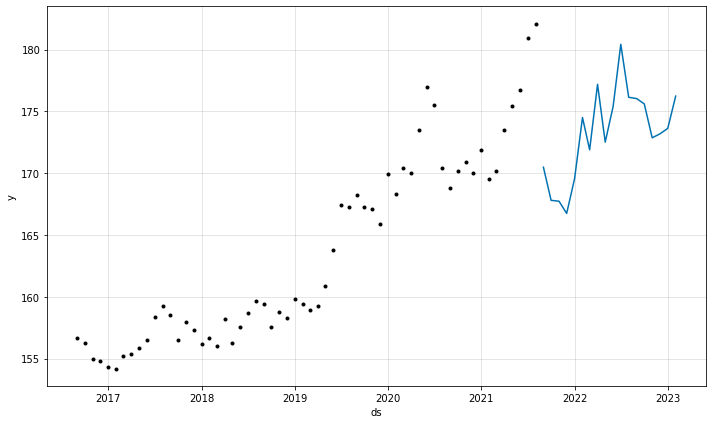

In [14]:
forecasts_plot = m.plot(forecast)

So, when you play around with including/excluding different regressors, you get TOTALLY different forecasts. NeuralProphet isn't helping us to decide which features should be included in the model, we still need to do that ourselves. 

It brings up an interesting question, too: what are the right periods to use for train/valid/test? What are our expectations for generalizability? It seems kind of silly to think that the relationships between these variables are stable (even non-linearly) over significant periods of time. And I think this is why linear models are still desirable: it's easier to reason about general relationships in linear models. Like if **x** variable has a spike or dip, then we expect a proportional response in **y**. I think we need to remember that we're dealing with VERY high-level economic indicators. These features are extremely far from "the raw data". 

But let's think about this. What kind of model would we expect to work well? For many categories, there is certainly a seasonality component (with the actual seasons) - especially fruits and vegetables. (Though I would guess that the magnitude of the seasonality effect would be reduced as the percentage of fruits and veg imported increases... can we get a signal on this?)

If we're just doing a forecast similar to last year (i.e. Canada-wide category-based CPI forecast) I think we should stick with relatively simple models and do a similar experiment with feature inclusion/exlusion and be very deliberate about what we select as the validation period. Do we want a model/method that would have been accurate in the last 10 years or just in the last 2? 